In [1]:
%matplotlib inline
%load_ext autoreload      
%autoreload 2     

import sys
import copy
import numpy as np
from numpy import sqrt, pi, exp, cos, sin
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.append("../")
from qo_simulator_2ph import QOsimulator_2ph as QOsimulator_2ph
sys.path.append("../lib/")
from _qo_simulator import _QOsimulator
path_to_qo_object = "../qo_object/"
sys.path.append(path_to_qo_object)
from qo_object import QOobject, Mirror, BeamSplitter, PolarizationRotator
path_to_qo_beam = "../qo_beam/"
sys.path.append(path_to_qo_beam)
from qo_beam import QObeam

## Entanglement

entanglement: str or None
- None: Independent two photons
- "Phi+": (|theta_pol_a, theta_pol_a> + |theta_pol_b, theta_pol_b>)/sqrt(2)
- "Phi-": (|theta_pol_a, theta_pol_a> - |theta_pol_b, theta_pol_b>)/sqrt(2)
- "Psi+": (|theta_pol_a, theta_pol_b> + |theta_pol_b, theta_pol_a>)/sqrt(2)
- "Psi-": (|theta_pol_a, theta_pol_b> - |theta_pol_b, theta_pol_a>)/sqrt(2)

See the definition in https://en.wikipedia.org/wiki/Bell_state

In [2]:
## Space parameters
N       = [2*256, 256]   # number of grid in the x and y directions
L       = [2*10*pi, 10*pi] # Size of space in the x and y dicrections
calc_pol=True

## Photon parameters
x0_a      = L[0]/2   # initial position x
y0_a      = L[1]/2   # initial position y
x0_b      = x0_a     # initial position x
y0_b      = y0_a     # initial position y
kx0_a     = -10.0     # center of initial k-space distribution 
ky0_a     = 0.0
kx0_b     = -kx0_a
ky0_b     = ky0_a
sigma = 2.0
sigma_x_a = sigma
sigma_y_a = sigma
sigma_x_b = sigma
sigma_y_b = sigma
sa=[x0_a, y0_a, kx0_a, ky0_a, sigma_x_a, sigma_y_a]
sb=[x0_b, y0_b, kx0_b, ky0_b, sigma_x_b, sigma_y_b]

theta_pol_a = 0.0   # linear polarization angle
theta_pol_b = pi/2  # linear polarization angle
entanglement= "Phi+"

theta_rot_1 = 0
theta_rot_2 = pi/2

## Time evolution 
dt       = 0.1
t_max    = 25
n_divide = 5

In [3]:
## set beam
beam_a = QObeam(N, L, *sa,  theta_pol=theta_pol_a)
beam_b = QObeam(N, L, *sb,  theta_pol=theta_pol_b)

# Create QOobject

----> optimizing omega_j for Polarization rotator...
----> Result: omega_j=1.185546, diff_prob=0.000149



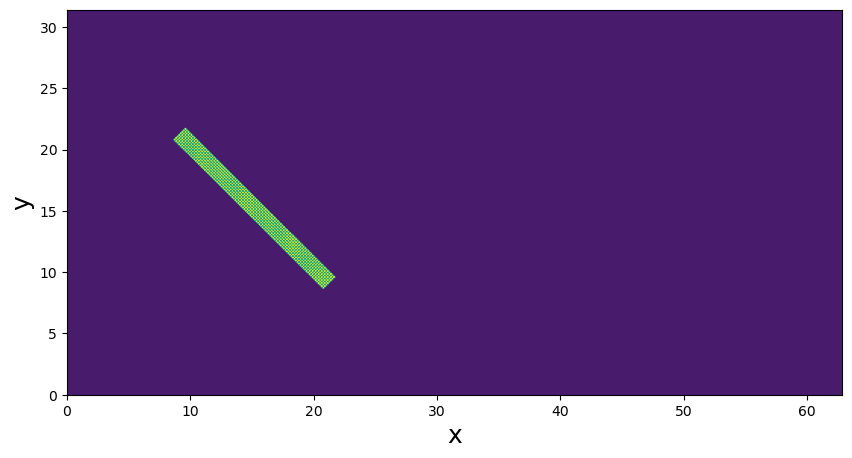

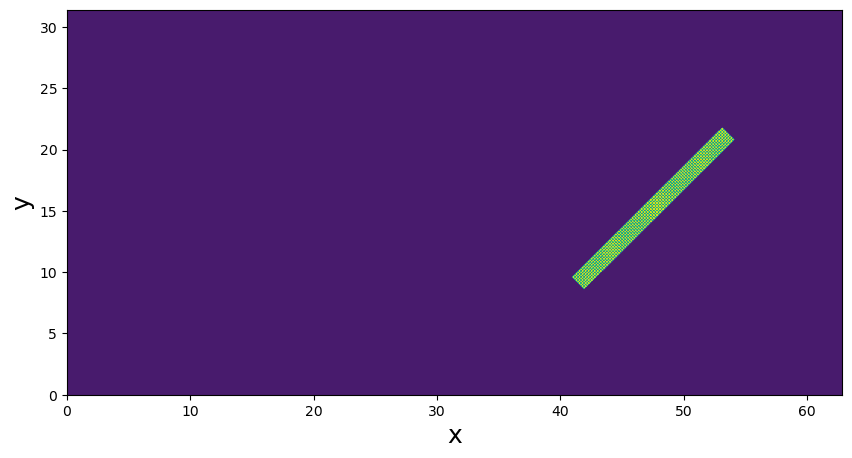

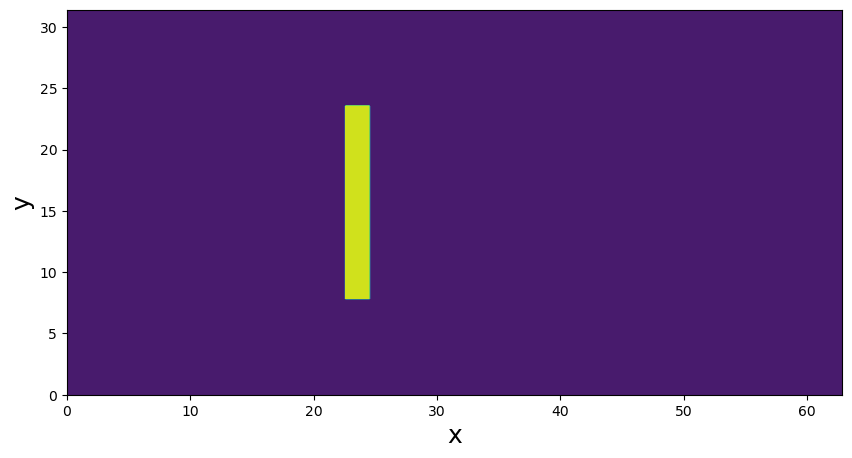

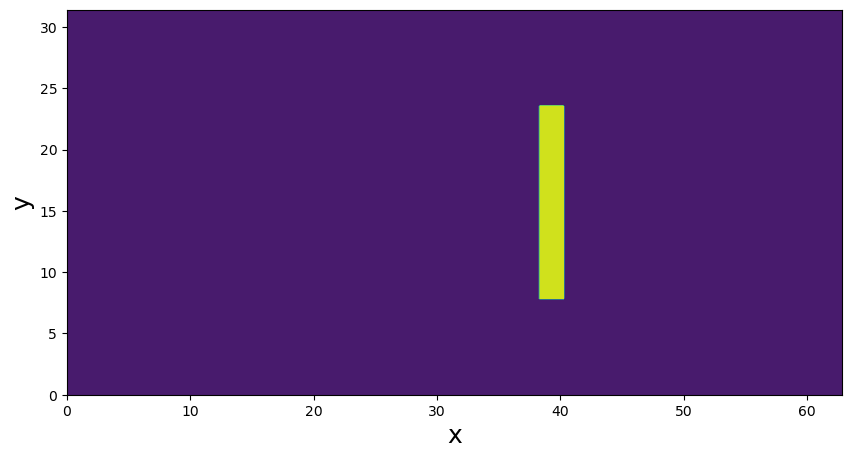

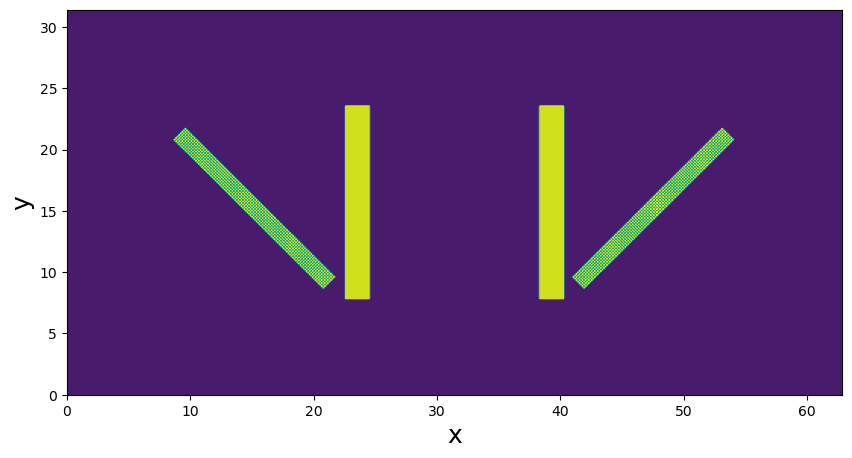

In [4]:
## adjustment parameter
dn=4

## mirror1
center_nx = int(N[0]/4 -dn)
center_ny = int(N[1]/2 -dn)
mirror1 = Mirror(N, L, center_nx, center_ny, size=1, angle=135, beam=beam_a, which_pol="V")
mirror1.show()

## mirror2
center_nx = int(N[0]/4*3 +dn)
center_ny = int(N[1]/2   -dn)
mirror2 = Mirror(N, L, center_nx, center_ny, size=1, angle=45, beam=beam_b, which_pol="V")
mirror2.show()

## pol_rotator1
center_nx = int(N[0]/4*1.5)
center_ny = int(N[1]/2)
pol_rotator1 = PolarizationRotator(N, L, center_nx, center_ny, size=1.0, angle=90, beam=beam_a, theta_rot=theta_rot_1)
pol_rotator1.show()

omega_j_opt = pol_rotator1.omega_j

## pol_rotator2
center_nx = int(N[0]/4*2.5)
center_ny = int(N[1]/2)
pol_rotator2 = PolarizationRotator(N, L, center_nx, center_ny, size=1.0, angle=90, beam=beam_a, omega_j=omega_j_opt, theta_rot=theta_rot_2)
pol_rotator2.show()

## plot objects
object_list = [mirror1, mirror2, pol_rotator1, pol_rotator2]
QOobject.show_all(object_list)

# Mainroutine

In [5]:
def gen_show_tlist(t_max, n_divide):
    tlist = []
    for i in range(int(t_max/dt)+1):
        t = i*dt
        tlist.append(t)
    res = [ elem[0] for elem in np.array_split(tlist, n_divide)]
    res.append(tlist[-1])
    return  res

def show_info(qosim, phi, t):
    print("#------- t=", round(t,3))
    prob_2ph=phi.phph.probability()
    prob_Aph = phi.Aph.probability()
    prob_phA = phi.phA.probability()
    prob_AA = phi.AA.probability()
    print("|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 = ", 
          round(prob_2ph,5),round(prob_Aph,5), round(prob_phA,5), round(prob_AA, 5),
         )
    print("sum |c|^2=", round(prob_2ph+prob_Aph+prob_phA+prob_AA, 5))
    # Energy
    eF=qosim.calc_EF(phi)
    eA=qosim.calc_EA(phi)
    eI=qosim.calc_EI(phi)
    econst=qosim.calc_Econst()
    print("E_F, E_A, E_I, econst =", round(eF,5), round(eA,5), round(eI,5), round(econst,5))
    print("Total energy = ", round(eF + eA + eI + econst, 5))
    print("Total energy - econst = ", round(eF + eA + eI, 5))
    ## Check sum of photon number density
    mat = np.zeros((qosim.N[0], qosim.N[1]))
    for _obj in qosim.objects:
        for idx in _obj.atom_pos_indices:
            mat[idx[0],idx[1]] = 1
    density = phi.phph.partial_density(_in="rr")
    if qosim.calc_pol == False:
        im, title = qosim.show(density,t)
    elif qosim.calc_pol == True:
        interval_of_cf = np.linspace(0,0.001,11)
        density = phi.phph.partial_density(_in="rr")
        im, title = qosim.show(density[0], t, levels=interval_of_cf, extend="both")
        plt.contour(qosim.qosim_1ph_a.x, qosim.qosim_1ph_a.y, mat.T, colors="gray")
        plt.title("t=%.2f, |H> part" % t, fontsize=18)
        im, title = qosim.show(density[1], t, cmap="inferno", levels=interval_of_cf, extend="both")
        plt.contour(qosim.qosim_1ph_a.x, qosim.qosim_1ph_a.y, mat.T, colors="gray")
        plt.title("|V> part", fontsize=18)
    plt.show()
    
show_tlist = gen_show_tlist(t_max, n_divide=n_divide)

entanglement= Phi+


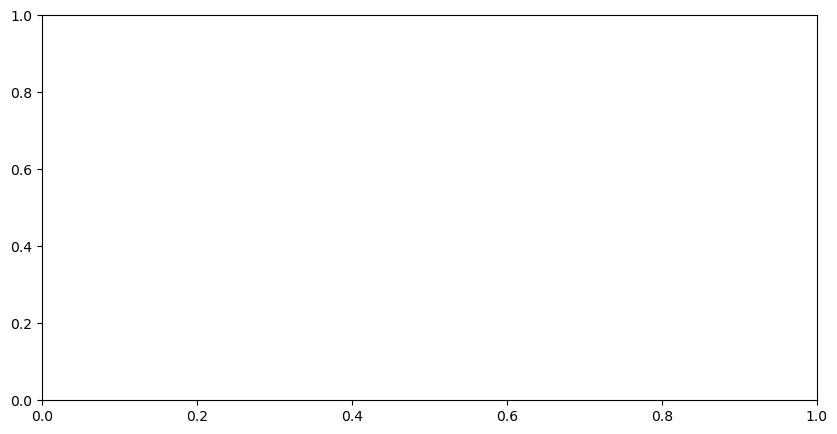

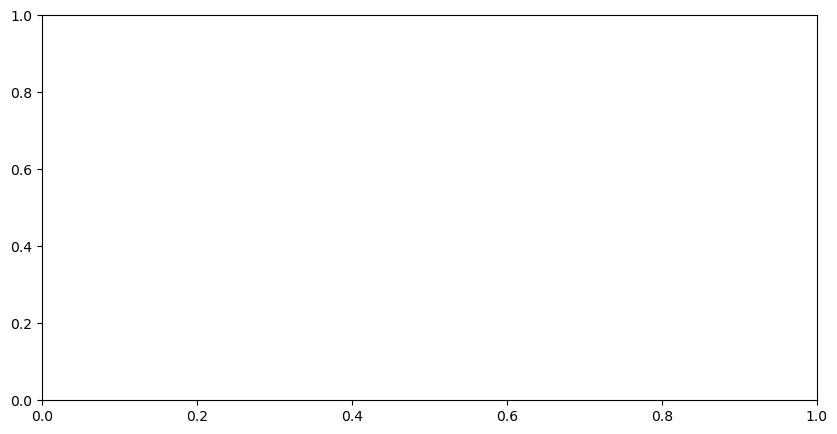

In [6]:
qosim = QOsimulator_2ph(N, L, dt, beams = [beam_a, beam_b], objects=object_list,  calc_pol=calc_pol, entanglement=entanglement)

#------- t= 0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 20.0125 0.0 0.0 -25551.99018
Total energy =  -25531.97768
Total energy - econst =  20.0125


/Users/junpei/miniforge3/envs/qosim/lib/python3.11/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


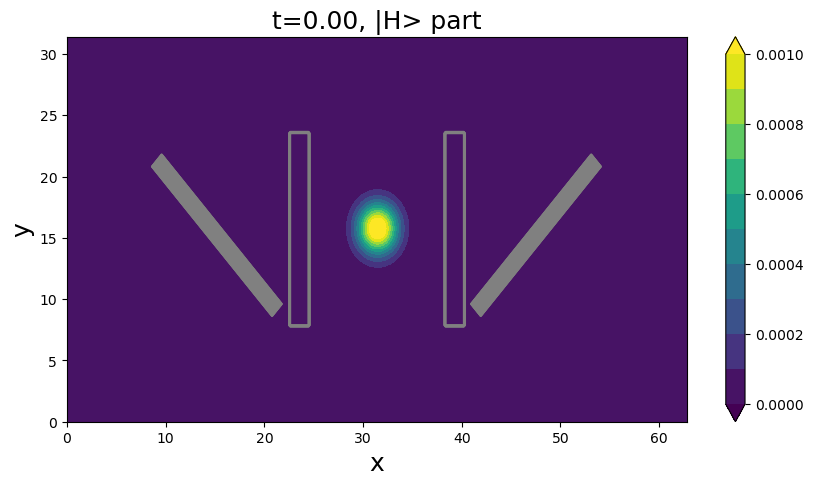

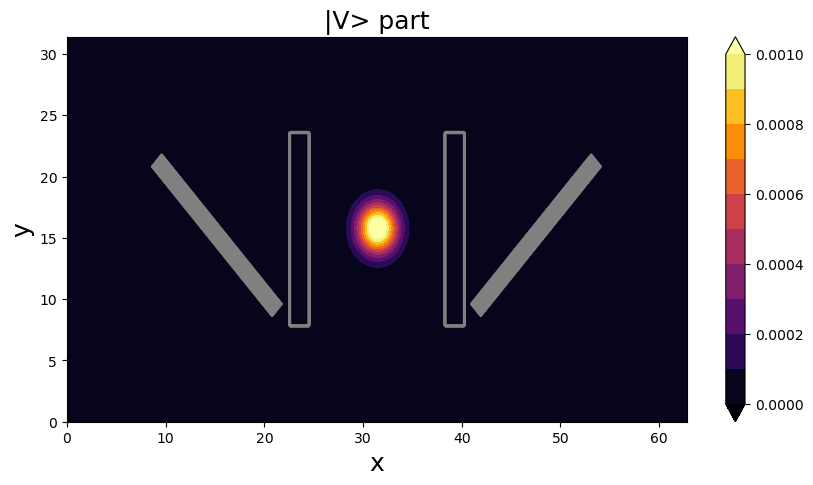

In [8]:
init_phi = qosim.gen_initial_state()
show_info(qosim, init_phi, t=0)

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 20.0125 0.0 0.0 -25551.99018
Total energy =  -25531.97768
Total energy - econst =  20.0125


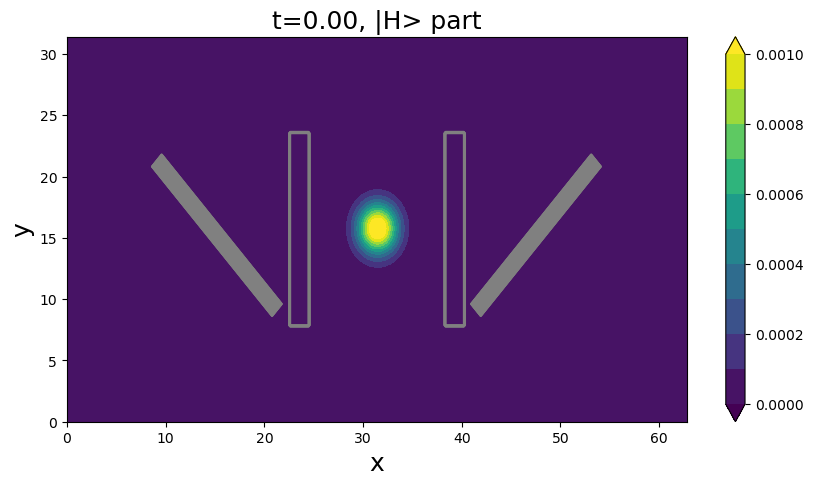

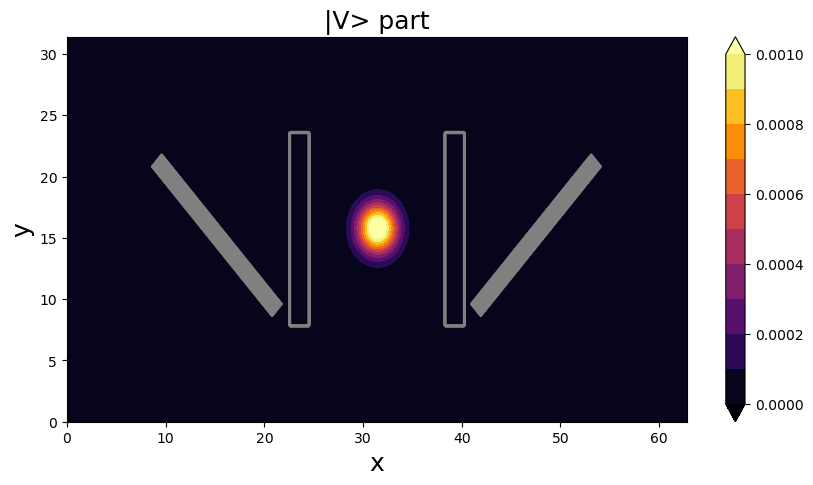

#------- t= 5.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.98314 0.00776 0.00902 7e-05
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 19.54181 0.00034 0.12381 -25551.99018
Total energy =  -25532.32422
Total energy - econst =  19.66596


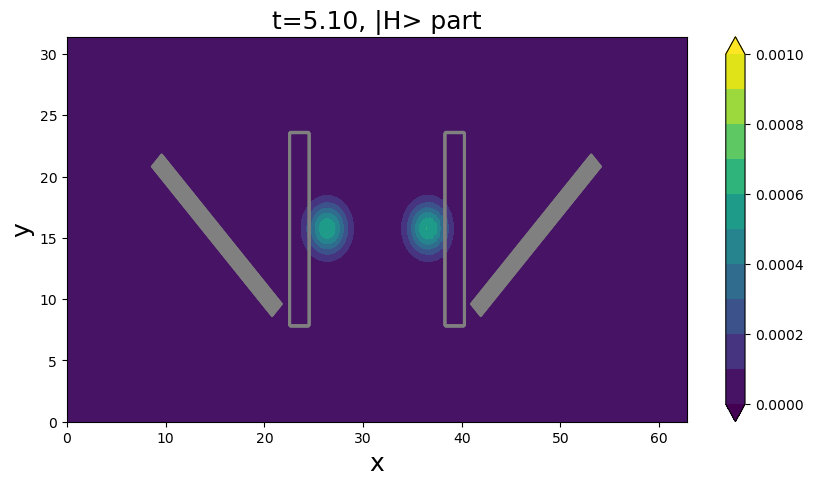

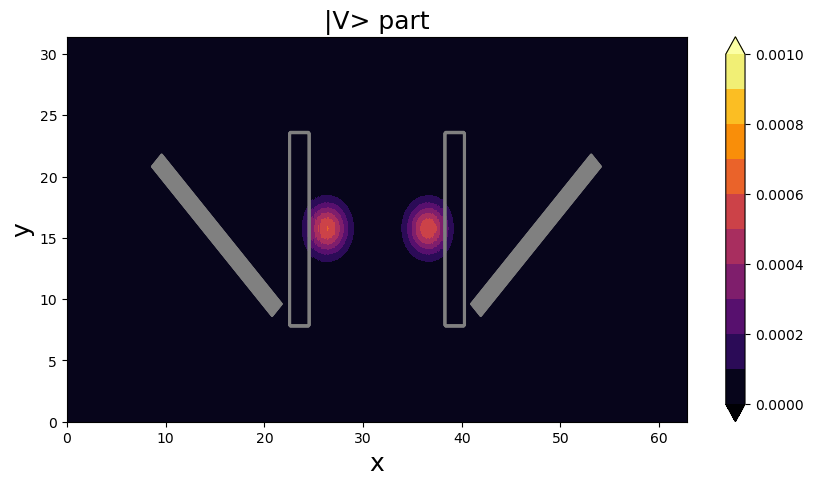

#------- t= 10.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.95401 0.02376 0.02169 0.00053
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 18.73553 0.00256 0.38153 -25551.99018
Total energy =  -25532.87057
Total energy - econst =  19.11962


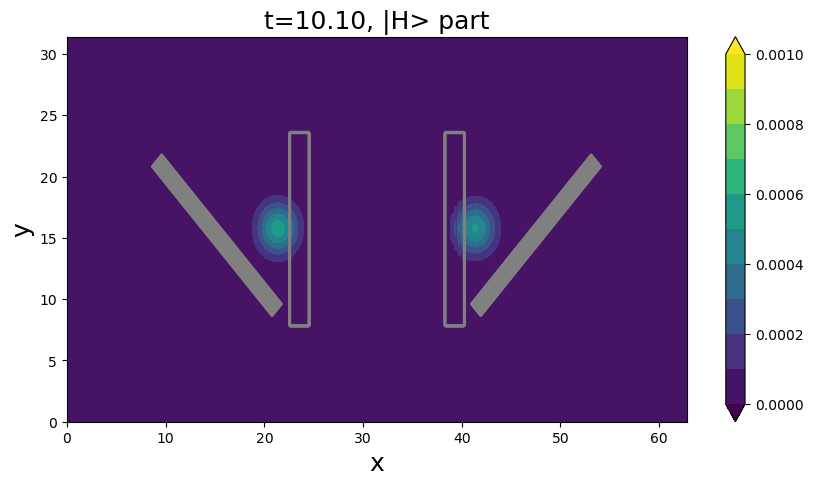

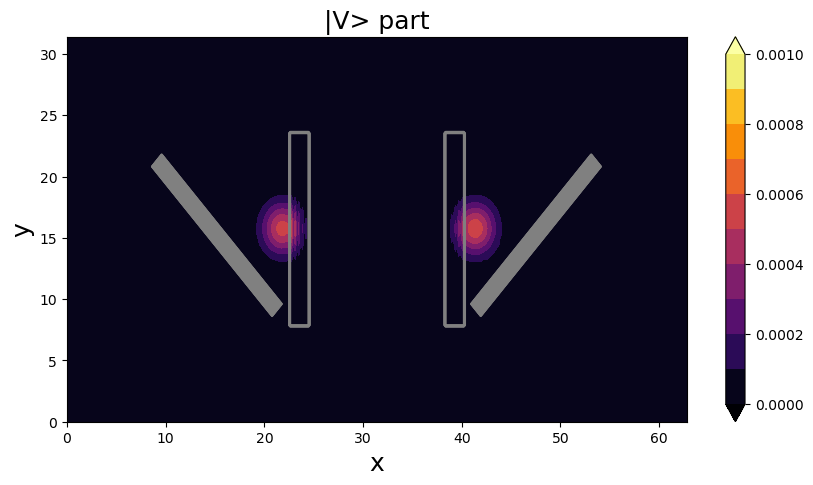

#------- t= 15.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.97404 0.01213 0.01382 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 19.48461 3e-05 0.00074 -25551.99018
Total energy =  -25532.50481
Total energy - econst =  19.48538


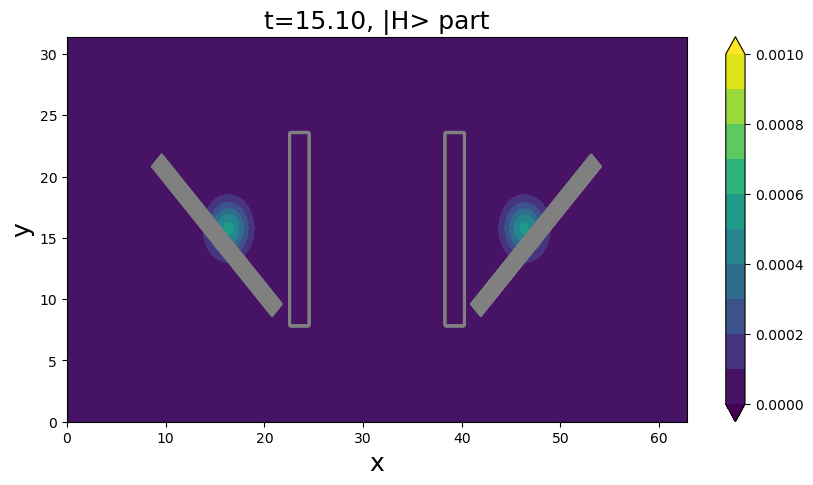

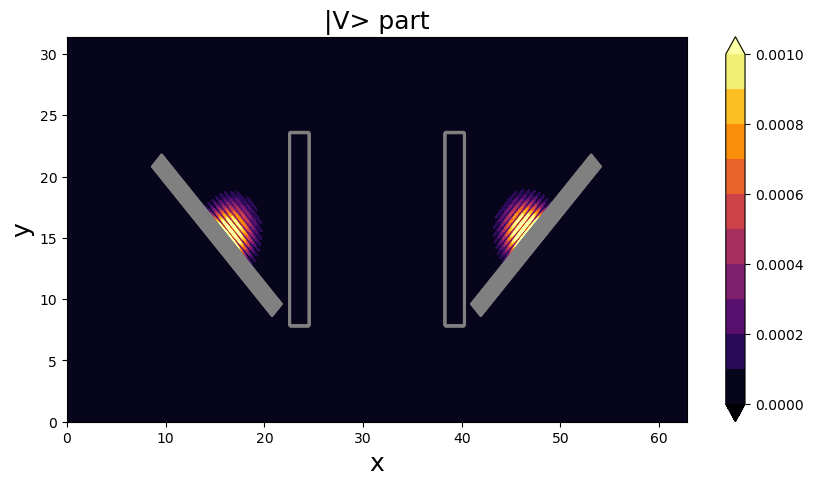

#------- t= 20.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99414 0.00345 0.00241 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 19.89132 1e-05 0.00178 -25551.99018
Total energy =  -25532.09707
Total energy - econst =  19.89311


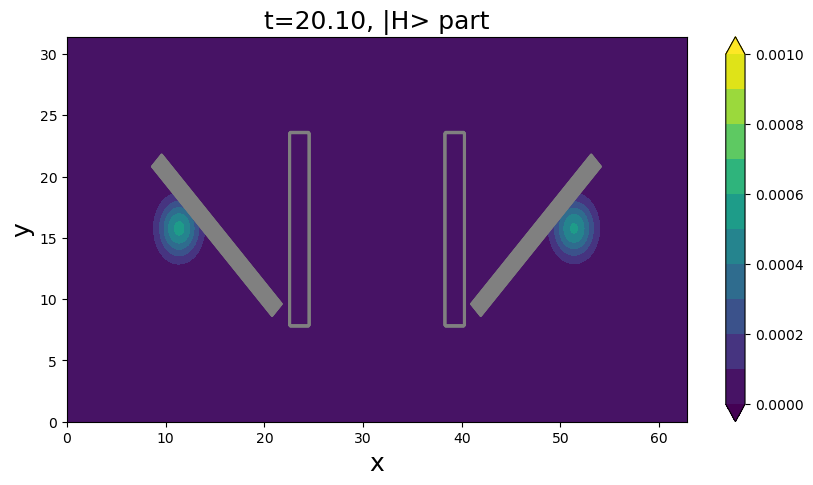

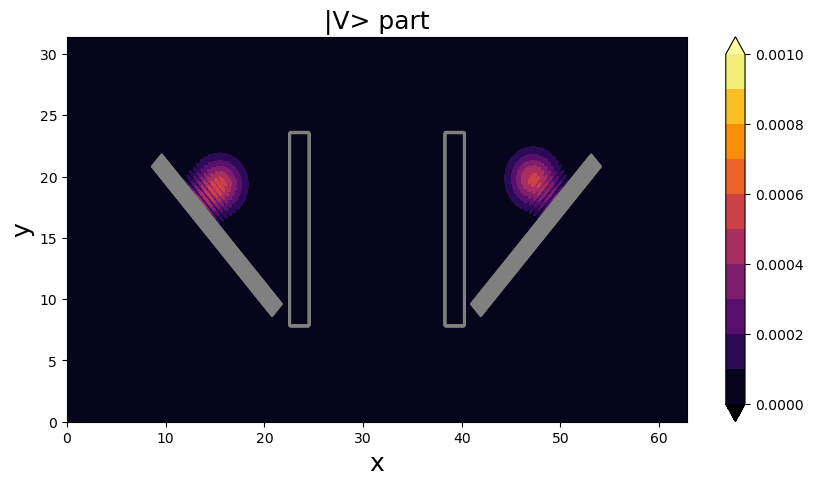

#------- t= 25.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99963 0.00018 0.00019 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 20.00211 0.0 0.00227 -25551.99018
Total energy =  -25531.9858
Total energy - econst =  20.00438


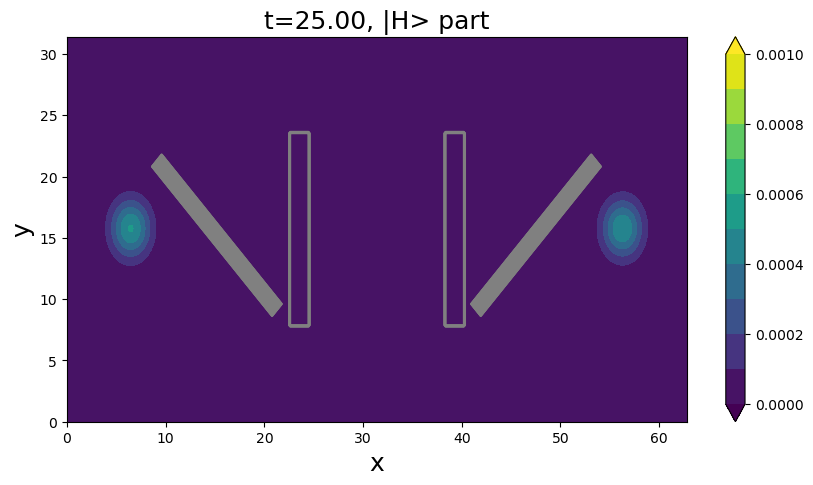

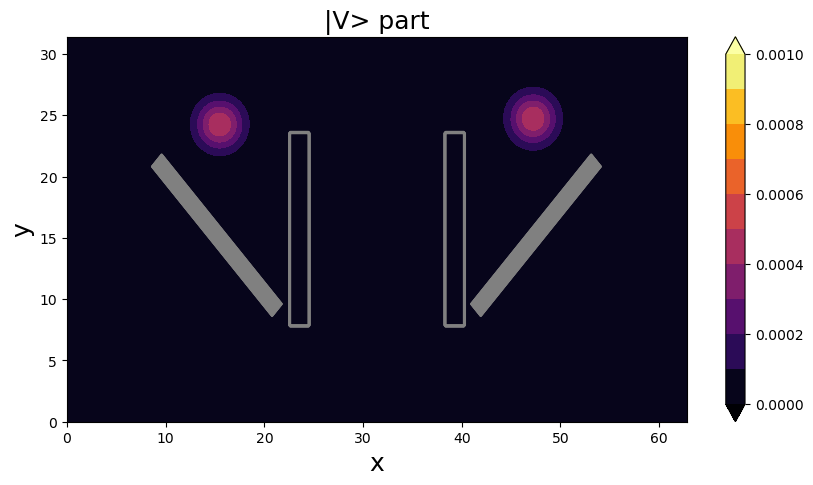

CPU times: user 54.9 s, sys: 2.81 s, total: 57.7 s
Wall time: 57.7 s


In [9]:
%%time
for i in range(int(t_max/dt)+1):
    t = i*dt
    if i == 0:
        phi = copy.deepcopy(init_phi)
    if t in show_tlist:
        show_info(qosim, phi, t)
    ##
    phi = qosim.suzuki_trotter_step(phi)

# Calculate $S(\theta)$

In [10]:
def calc_coin_probs(phi):
    csign1 = 1 if np.sign(cos(theta_rot_1))==0 else np.sign(cos(theta_rot_1))
    csign2 = 1 if np.sign(cos(theta_rot_2))==0 else np.sign(cos(theta_rot_2)) 
    ssign1 = 1 if np.sign(sin(theta_rot_1))==0 else np.sign(sin(theta_rot_1))
    ssign2 = 1 if np.sign(sin(theta_rot_2))==0 else np.sign(sin(theta_rot_2))   

    ## ++
    coscos = np.abs(phi.phph.states[0].rr["1"]) * (np.sum(np.abs(phi.phph.states[0].rr["2"][0])**2))**0.5
    sinsin = np.abs(phi.phph.states[1].rr["1"]) * (np.sum(np.abs(phi.phph.states[1].rr["2"][0])**2))**0.5
    P_pp = 2*(csign1*csign2*coscos + ssign1*ssign2*sinsin)**2
    coscos = np.abs(phi.phph.states[0].rr["2"]) * (np.sum(np.abs(phi.phph.states[0].rr["1"][0])**2))**0.5
    sinsin = np.abs(phi.phph.states[1].rr["2"]) * (np.sum(np.abs(phi.phph.states[1].rr["1"][0])**2))**0.5
    P_pp += 2*(csign1*csign2*coscos + ssign1*ssign2*sinsin)**2
    P_pp = P_pp /2.
    P_pp[1] = 0

    # --
    sinsin = np.abs(phi.phph.states[0].rr["1"]) * (np.sum(np.abs(phi.phph.states[0].rr["2"][1])**2))**0.5
    coscos = np.abs(phi.phph.states[1].rr["1"]) * (np.sum(np.abs(phi.phph.states[1].rr["2"][1])**2))**0.5
    P_nn = 2*(ssign1*ssign2*sinsin + csign1*csign2*coscos)**2
    sinsin = np.abs(phi.phph.states[0].rr["2"]) * (np.sum(np.abs(phi.phph.states[0].rr["1"][1])**2))**0.5
    coscos = np.abs(phi.phph.states[1].rr["2"]) * (np.sum(np.abs(phi.phph.states[1].rr["1"][1])**2))**0.5
    P_nn += 2*(ssign1*ssign2*sinsin + csign1*csign2*coscos)**2
    P_nn = P_nn /2.
    P_nn[0] = 0

    # -+
    sincos = np.abs(phi.phph.states[0].rr["1"]) * (np.sum(np.abs(phi.phph.states[0].rr["2"][0])**2))**0.5
    cossin = np.abs(phi.phph.states[1].rr["1"]) * (np.sum(np.abs(phi.phph.states[1].rr["2"][0])**2))**0.5
    P_np = 2*(ssign1*csign2*sincos - csign1*ssign2*cossin)**2
    sincos = np.abs(phi.phph.states[0].rr["2"]) * (np.sum(np.abs(phi.phph.states[0].rr["1"][0])**2))**0.5
    cossin = np.abs(phi.phph.states[1].rr["2"]) * (np.sum(np.abs(phi.phph.states[1].rr["1"][0])**2))**0.5
    P_np += 2*(ssign1*csign2*sincos - csign1*ssign2*cossin)**2
    P_np = P_np /2.
    P_np[0] = 0

    # +-
    cossin = np.abs(phi.phph.states[0].rr["1"]) * (np.sum(np.abs(phi.phph.states[0].rr["2"][1])**2))**0.5
    sincos = np.abs(phi.phph.states[1].rr["1"]) * (np.sum(np.abs(phi.phph.states[1].rr["2"][1])**2))**0.5
    P_pn = 2*(csign1*ssign2*cossin - ssign1*csign2*sincos)**2
    cossin = np.abs(phi.phph.states[0].rr["2"]) * (np.sum(np.abs(phi.phph.states[0].rr["1"][1])**2))**0.5
    sincos = np.abs(phi.phph.states[1].rr["2"]) * (np.sum(np.abs(phi.phph.states[1].rr["1"][1])**2))**0.5
    P_pn += 2*(csign1*ssign2*cossin - ssign1*csign2*sincos)**2
    P_pn = P_pn /2.
    P_pn[1] = 0

    return P_pp, P_nn, P_np, P_pn

In [11]:
def plot_s_theta_r(field, qosim):
    fig_coef = N[0]/N[1]
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1, 1, 1)
    x = np.linspace(0, L[0], N[0])
    y = np.linspace(0, L[1], N[1])
    plt.xlabel("x", fontsize=18)
    plt.ylabel("y", fontsize=18)
    interval_of_cf = np.linspace(-0.0005,0.0005,10)
    mat = np.zeros((N[0], N[1]))
    for _obj in [mirror1, mirror2, pol_rotator1, pol_rotator2]:
        for idx in _obj.atom_pos_indices:
            mat[idx[0],idx[1]] = 1
    im1 = ax1.contourf(x, y, field[0].T + field[1].T, cmap="bwr", levels=interval_of_cf, extend="both")
    ax1.contour(x, y, mat.T, colors="gray")
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="3%", pad=0.1)
    plt.colorbar(im1, cax=cax1)
    # plt.savefig("fig/S_theta_r.eps", bbox_inches="tight")

entanglement= Phi+
entanglement= Phi+
entanglement= Phi+
entanglement= Phi+
CPU times: user 3min 22s, sys: 20.3 s, total: 3min 42s
Wall time: 3min 42s


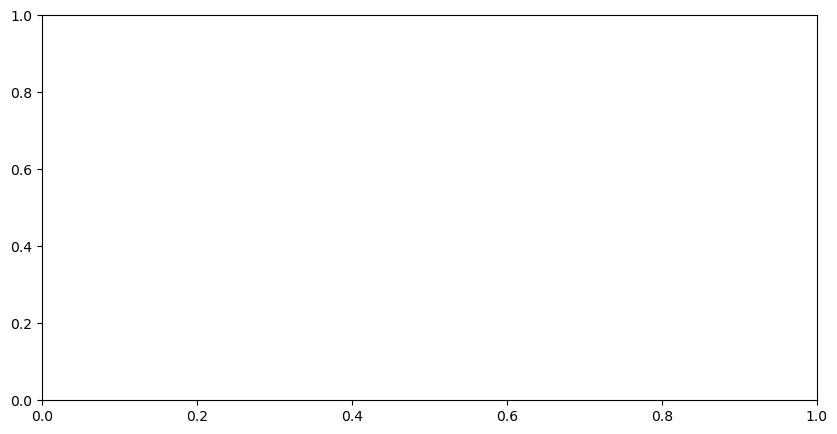

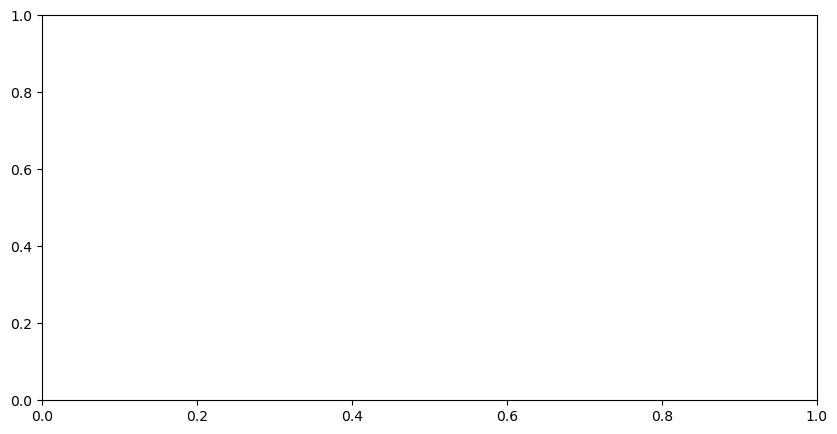

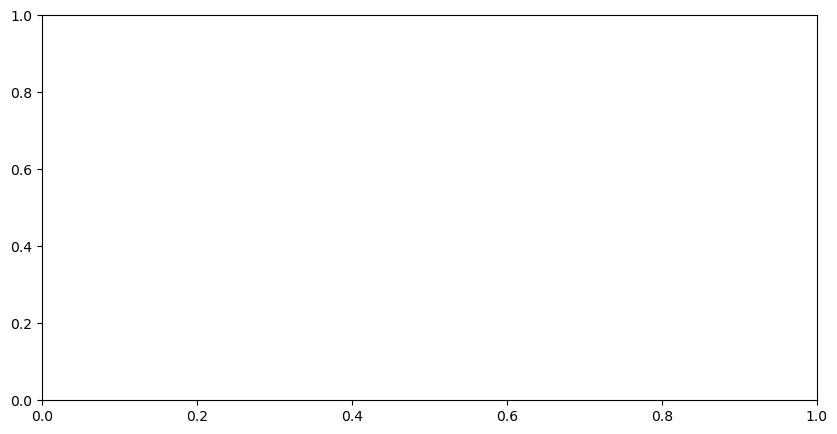

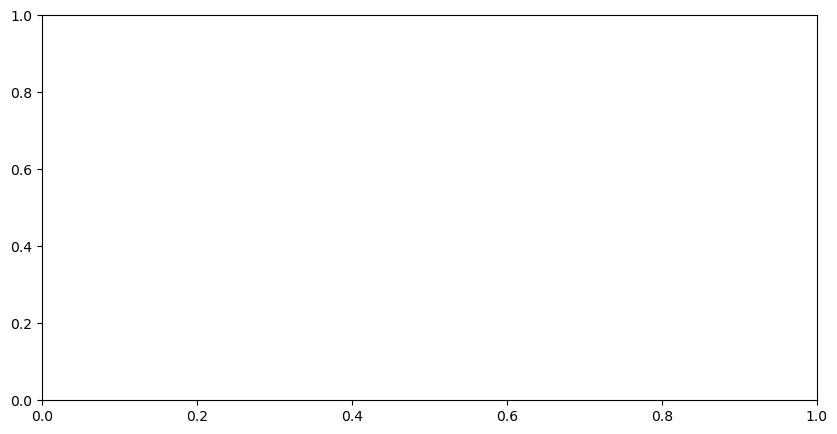

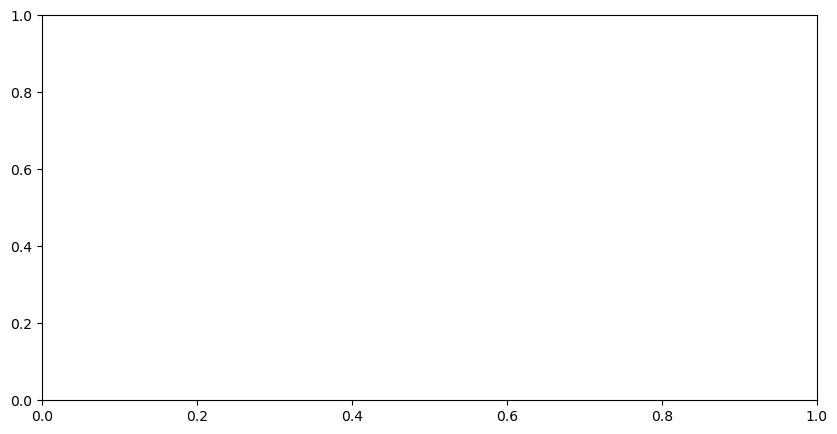

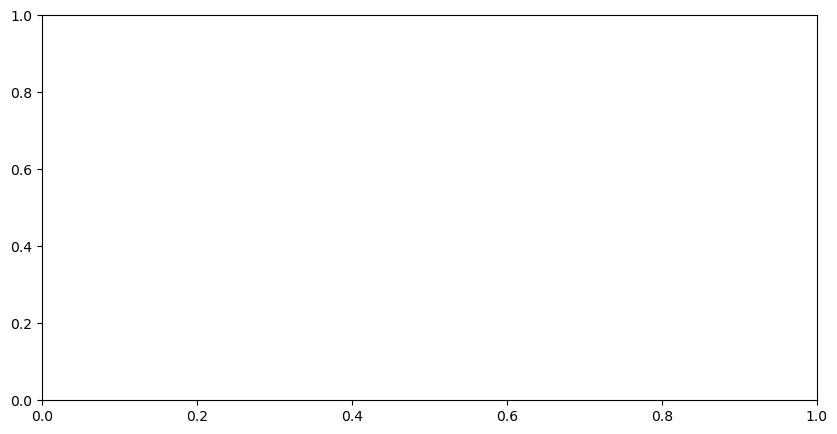

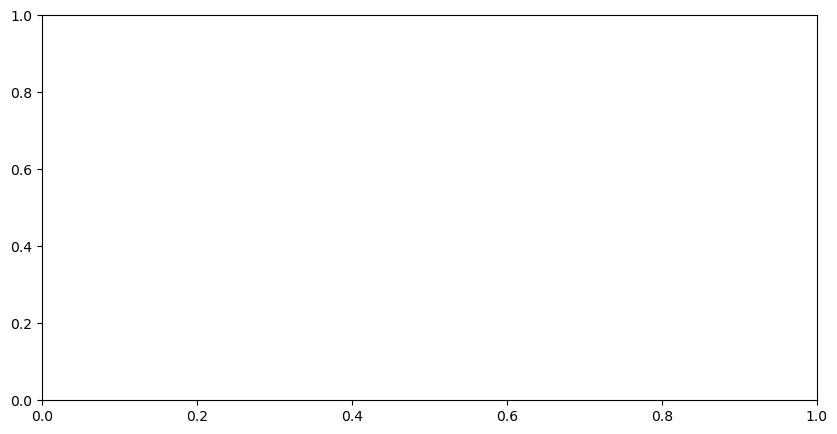

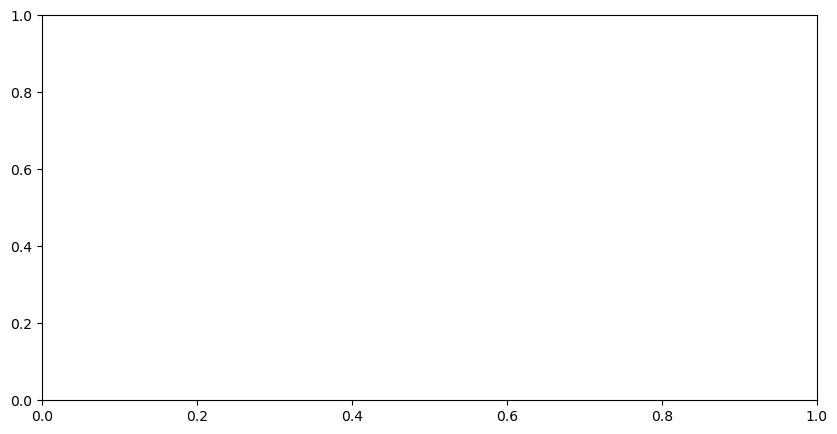

In [12]:
%%time
theta_list = [pi/8] #np.linspace(0,pi/2,8+1)
S_theta=[]
for theta in theta_list:
    theta_pairs=[[0.0,theta],[theta,2*theta],[2*theta, 3*theta],[0,3*theta]]
    S_theta_r = np.zeros_like(init_phi.phph.states[0].rr["1"], dtype="float64")
    for j, theta_pair in enumerate(theta_pairs):
        theta_rot_1 = theta_pair[0]
        theta_rot_2 = theta_pair[1]
        ## pol_rotator1
        center_nx = int(N[0]/4*1.5)
        center_ny = int(N[1]/2)
        pol_rotator1 = PolarizationRotator(N, L, center_nx, center_ny, size=1.0, angle=90, beam=beam_a, omega_j=1.185546, theta_rot=theta_rot_1)
        ## pol_rotator2
        center_nx = int(N[0]/4*2.5)
        center_ny = int(N[1]/2)
        pol_rotator2 = PolarizationRotator(N, L, center_nx, center_ny, size=1.0, angle=90, beam=beam_a, omega_j=1.185546, theta_rot=theta_rot_2)
        ##
        object_list = [mirror1, mirror2, pol_rotator1, pol_rotator2]
        if theta_rot_1==0:
            object_list = [mirror1, mirror2, pol_rotator2]
        qosim = QOsimulator_2ph(N, L, dt, beams = [beam_a, beam_b], objects=object_list,  calc_pol=calc_pol, entanglement=entanglement)
        for i in range(int(t_max/dt)+1):
            t = i*dt
            if i == 0:
                phi = copy.deepcopy(init_phi)
            ##
            phi = qosim.suzuki_trotter_step(phi)
        P_pp, P_nn, P_np, P_pn = calc_coin_probs(phi)
        E_theta_r = P_pp + P_nn - P_np - P_pn
        if j==3:
            S_theta_r -= E_theta_r
        else:
            S_theta_r += E_theta_r
    S_theta.append(np.sum(S_theta_r))

S_theta = 2.811983


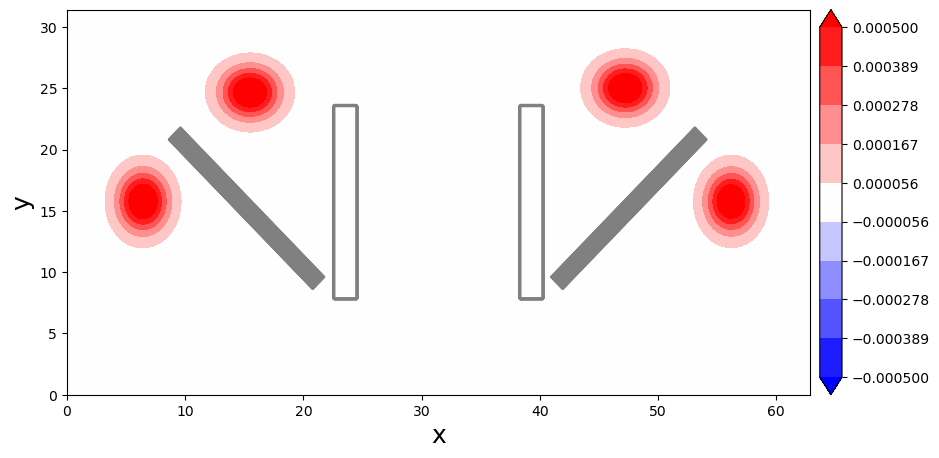

In [13]:
plot_s_theta_r(S_theta_r, qosim)
print("S_theta = %.6f" % np.sum(S_theta_r))

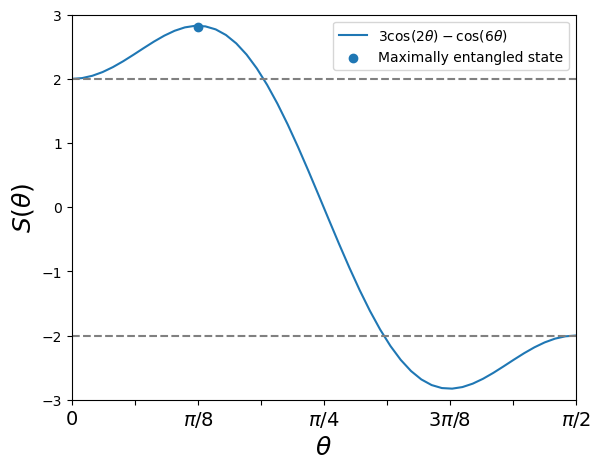

In [14]:
plt.figure(figsize=(6.5,5))
x = np.linspace(0,pi/2)
plt.plot(x, 3*np.cos(2*x)-np.cos(3*2*x), label=r"$3\cos(2\theta)-\cos(6\theta)$")
plt.scatter(theta_list, S_theta, label="Maximally entangled state")
##
plt.hlines( 2, 0, pi/2, ls="--", color="gray")
plt.hlines( -2, 0, pi/2, ls="--", color="gray")
plt.xlabel(r"$\theta$", fontsize=18)
plt.ylabel(r"$S(\theta)$", fontsize=18)
plt.xlim(0,pi/2)
plt.ylim(-3,3)
plt.xticks(np.linspace(0,pi/2,8+1), [r"$0$","",r"$\pi/8$","",r"$\pi/4$","",r"$3\pi/8$","",r"$\pi/2$"], fontsize=14)
plt.legend()
# plt.savefig("fig/S_theta.eps", bbox_inches="tight")